In [1]:
import numpy as np
import pandas as pd
import csv
import os

import nltk
import string, unicodedata
from nltk import word_tokenize, sent_tokenize
from nltk.corpus import stopwords
from nltk.stem import LancasterStemmer, WordNetLemmatizer
import re

from sklearn import model_selection, preprocessing, linear_model, naive_bayes, metrics, svm
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, classification_report
from sklearn import decomposition, ensemble
from keras import layers, models, optimizers
sw = stopwords.words('english')
np.array(sw)
# from tensorflow.keras.utils import plot_model

import warnings
warnings.filterwarnings('ignore')

In [2]:
#load data 

def load_data(file):
    data = pd.read_csv(file, names=["class index","title","description"])
    return data

train_data = load_data('train.csv')
test_data = load_data('test.csv')

In [3]:
train_data.sample(6)

,class index,title,description
116775,2,Dry spell dooms Nets,Forget the 10 miles that separates their two h...
45495,2,Pele: Brazilians should strike,Brazilian legend Pele has suggested that footb...
88489,1,Minister urges hunting compromise,Rural Affairs Minister Alun Michael urges peer...
98769,3,Mylan not interested in Icahn talks,Mylan Laboratories Inc. #39;s board Monday shu...
83625,2,Former NBA pro sharing his skills,"Newfields, N.H., is an unlikely place for a ba..."
62789,2,Myskina defends title in Moscow,"Moscow, Russia (Sports Network) - Anastasia My..."


In [4]:
train_data['description'][57819]

'Some television networks are racing to develop eye-catching score boxes. Fox, for example, now has fire coming out of its baseball scores.'

In [5]:
#shape of data 

def data_shape(data):
    return data.shape

print("train data shape",data_shape(train_data))
print("test data shape",data_shape(test_data))

train data shape (120000, 3)
test data shape (7600, 3)


reducing shape of data to avoid memory error

In [6]:
# Step 1: Sample 10,000 rows for training
train_sample = train_data.sample(n=10000, random_state=42)

# Step 2: Remove the training sample rows from the original DataFrame
# remaining_data = train_data.drop(train_sample.index)

# Step 3: Sample 3,000 rows for testing from the remaining data
test_sample = test_data.sample(n=3000, random_state=42)

# Check the shapes of the resulting DataFrames
print(f'Training set shape: {train_sample.shape}')
print(f'Testing set shape: {test_sample.shape}')

Training set shape: (10000, 3)
Testing set shape: (3000, 3)


In [7]:
train_sample

,class index,title,description
71787,3,"BBC set for major shake-up, claims newspaper","London - The British Broadcasting Corporation,..."
67218,3,Marsh averts cash crunch,Embattled insurance broker #39;s banks agree t...
54066,2,"Jeter, Yankees Look to Take Control (AP)",AP - Derek Jeter turned a season that started ...
7168,4,Flying the Sun to Safety,When the Genesis capsule comes back to Earth w...
29618,3,Stocks Seen Flat as Nortel and Oil Weigh,NEW YORK (Reuters) - U.S. stocks were set to ...
...,...,...,...
62026,4,"In Another Reversal, Intel Kills 4 Gig Chip",Leading chipmaker Intel revealed Thursday that...
111794,1,Bush Taps Nicholson for Veterans Affairs (AP),AP - President Bush announced Thursday he was ...
38440,3,Stocks Inch Up After Durable Goods Report,NEW YORK (Reuters) - U.S. stocks rose modestl...
4197,3,Fleet workers get pink slips,STAFF WRITER; Staff writers Alan J. Wax and Re...


In [8]:
#duplicates 

def check_duplicates(data):
    return data.duplicated().sum()

print("train data duplicates",check_duplicates(train_sample))
print("test data duplicates",check_duplicates(test_sample))

train data duplicates 0
test data duplicates 0


In [9]:
#null 

def check_missing(data):
    return data.isnull().sum()

print("train data missings",check_duplicates(train_sample))
print("test data missing",check_duplicates(test_sample))

train data missings 0
test data missing 0


In [10]:
train_sample['class index'].value_counts()

class index
2    2549
4    2515
3    2471
1    2465
Name: count, dtype: int64

In [11]:
train_corpus = train_sample.description
test_corpus = test_sample.description

# Text Preprocessing Pileline 

**Lowercasing:** Converting all characters to lowercase.

**Tokenization:** Splitting text into words or tokens.

**Removing Stopwords:** Removing common words like "and", "is", "in".

**Lemmatization:** Reducing words to their base or root form.

**Removing Special Characters:** Removing non-alphanumeric characters.

**Vectorization:** Converting text into a numerical representation.

In [12]:
### 1. Lowercasing

# def lowercase(data):
#     data = data.lower()
#     return data

In [13]:
###2. Removing Special Characters (using regex)

def special_char(data):
    data = re.sub(r'[^a-zA-Z\s]', '', data)
    return data

In [14]:
###3. Tokenization (using NLTK)

def tokenization(data):
    tokens = word_tokenize(data)
    return tokens

In [15]:
###4. Removing Stopwords

def rem_stopwords(data):
    text = [text.lower() for text in data if text not in sw]
    return text

In [16]:
###5. Lemmatization

def lemmatize(data):
    lm = WordNetLemmatizer()
    data = [lm.lemmatize(word) for word in data]
    return data

In [17]:
def preprocess(text):
#     text = lowercase(text)
    text = special_char(text)
    tokens = tokenization(text)
    tokens = rem_stopwords(tokens)
    lemmas = lemmatize(tokens)
    return ' '.join(lemmas)
    

In [18]:
# Apply preprocessing to the DataFrame column
train_sample['processed_description']  = train_sample['description'].apply(preprocess)
test_sample['processed_description'] = test_sample['description'].apply(preprocess)

In [19]:
train_sample

,class index,title,description,processed_description
71787,3,"BBC set for major shake-up, claims newspaper","London - The British Broadcasting Corporation,...",london the british broadcasting corporation wo...
67218,3,Marsh averts cash crunch,Embattled insurance broker #39;s banks agree t...,embattled insurance broker bank agree waive cl...
54066,2,"Jeter, Yankees Look to Take Control (AP)",AP - Derek Jeter turned a season that started ...,ap derek jeter turned season started terrible ...
7168,4,Flying the Sun to Safety,When the Genesis capsule comes back to Earth w...,when genesis capsule come back earth sample su...
29618,3,Stocks Seen Flat as Nortel and Oil Weigh,NEW YORK (Reuters) - U.S. stocks were set to ...,new york reuters u stock set open near unchang...
...,...,...,...,...
62026,4,"In Another Reversal, Intel Kills 4 Gig Chip",Leading chipmaker Intel revealed Thursday that...,leading chipmaker intel revealed thursday manu...
111794,1,Bush Taps Nicholson for Veterans Affairs (AP),AP - President Bush announced Thursday he was ...,ap president bush announced thursday keeping h...
38440,3,Stocks Inch Up After Durable Goods Report,NEW YORK (Reuters) - U.S. stocks rose modestl...,new york reuters u stock rose modestly friday ...
4197,3,Fleet workers get pink slips,STAFF WRITER; Staff writers Alan J. Wax and Re...,staff writer staff writer alan j wax regina ma...


In [20]:
# train_corpus_preprocessed = preprocess(train_corpus)
# test_corpus_preprocessed = preprocess(test_corpus)

**Vectorization (using TF-IDF)**

In [21]:
# def vectorize(corpus):
#     vectorizer = TfidfVectorizer()  #max_features=10000
#     return vectorizer.fit_transform(corpus)

In [22]:
vectorizer = TfidfVectorizer(max_features=2000)  # Use the same max_features as in training

# Fit the vectorizer on the training data
train_x = vectorizer.fit_transform(train_sample['processed_description'])
test_x = vectorizer.transform(test_sample['processed_description'])

In [23]:
train_y = train_sample['class index']
test_y = test_sample['class index']

In [24]:
train_x.shape

(10000, 2000)

In [25]:
# Initialize and train the Random Forest model
rf_model = RandomForestClassifier(n_estimators=100)
rf_model.fit(train_x, train_y)

# Predict on test data
rf_pred = rf_model.predict(test_x)

# Evaluate the model
# print("Accuracy:", accuracy_score(test_y, rf_pred))
print("Classification Report:\n", classification_report(test_y, rf_pred))

Classification Report:
               precision    recall  f1-score   support

           1       0.84      0.82      0.83       759
           2       0.85      0.90      0.88       743
           3       0.78      0.78      0.78       713
           4       0.79      0.75      0.77       785

    accuracy                           0.81      3000
   macro avg       0.81      0.81      0.81      3000
weighted avg       0.81      0.81      0.81      3000



In [26]:
from sklearn.svm import SVC

# Initialize and train the SVM model
svm_model = SVC(kernel='linear')  # Linear kernel is often used for text classification
svm_model.fit(train_x, train_y)

# Predict on test data
svm_pred = svm_model.predict(test_x)

# Evaluate the model
print("Classification Report:\n", classification_report(test_y, svm_pred))


Classification Report:
               precision    recall  f1-score   support

           1       0.87      0.84      0.85       759
           2       0.91      0.93      0.92       743
           3       0.80      0.82      0.81       713
           4       0.83      0.82      0.82       785

    accuracy                           0.85      3000
   macro avg       0.85      0.85      0.85      3000
weighted avg       0.85      0.85      0.85      3000



In [27]:
from sklearn.naive_bayes import MultinomialNB

# Initialize and train the Naive Bayes model
nb_model = MultinomialNB()
nb_model.fit(train_x, train_y)

# Predict on test data
nb_pred = nb_model.predict(test_x)

# Evaluate the model

print("Classification Report:\n", classification_report(test_y, nb_pred))


Classification Report:
               precision    recall  f1-score   support

           1       0.88      0.86      0.87       759
           2       0.90      0.94      0.92       743
           3       0.82      0.81      0.81       713
           4       0.82      0.82      0.82       785

    accuracy                           0.86      3000
   macro avg       0.86      0.86      0.86      3000
weighted avg       0.86      0.86      0.86      3000



In [30]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

# Initialize the model
model = Sequential()
model.add(Dense(64, input_dim=train_x.shape[1], activation='relu'))  # Input layer
model.add(Dense(32, activation='relu'))  # Hidden layer
model.add(Dense(1, activation='sigmoid'))  # Output layer for binary classification

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
model.fit(train_x, train_y, epochs=10, batch_size=32, validation_split=0.2)

# Evaluate the model
loss, accuracy = model.evaluate(test_x, test_y)
print(f"Test Loss: {loss}")
print(f"Test Accuracy: {accuracy}")


Epoch 1/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.2408 - loss: -18.8445 - val_accuracy: 0.2595 - val_loss: -333.2520
Epoch 2/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.2401 - loss: -780.4654 - val_accuracy: 0.2595 - val_loss: -3071.8914
Epoch 3/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.2401 - loss: -4607.5601 - val_accuracy: 0.2595 - val_loss: -10431.3076
Epoch 4/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.2405 - loss: -13503.1250 - val_accuracy: 0.2595 - val_loss: -24164.2188
Epoch 5/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.2406 - loss: -29291.3594 - val_accuracy: 0.2595 - val_loss: -45551.1875
Epoch 6/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.2477 - loss: -52577.2930 - val_accuracy: 0.2595 - val_loss: -75845.2500
Epoch 7/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.2527 - loss: -85177.1250 - val_accuracy: 0.2595 - val_loss: -115581.1562
Epoch 8/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 0s

# Clustering 

In [31]:
from sklearn.decomposition import PCA 
from sklearn.cluster import KMeans 
import matplotlib.pyplot as plt

In [32]:
train_x

<10000x2000 sparse matrix of type '<class 'numpy.float64'>'
	with 131797 stored elements in Compressed Sparse Row format>

In [33]:
# reduce the dimensionality of the data using PCA 
pca = PCA(n_components=2) 
reduced_data = pca.fit_transform(train_x.toarray())

In [34]:
# cluster the documents using k-means 
num_clusters = 4
kmeans = KMeans(n_clusters=num_clusters, n_init=5, 
                max_iter=500, random_state=42) 
kmeans.fit(train_x) 

KMeans(max_iter=500, n_clusters=4, n_init=5, random_state=42)

In [36]:
# create a dataframe to store the results 
results = pd.DataFrame() 
results['document'] = train_sample['processed_description'] 
results['cluster'] = kmeans.labels_ 
  
# print the results 
results.sample(5)
  

,document,cluster
110863,reuters south american leader wednesdaylaunche...,2
25077,celtic put henri camara john hartson together ...,3
51365,union executive italy alitalia reach deal gove...,3
106186,new york reuters application u home mortgage f...,0
110360,indonesia likely ask organization petroleum ex...,0


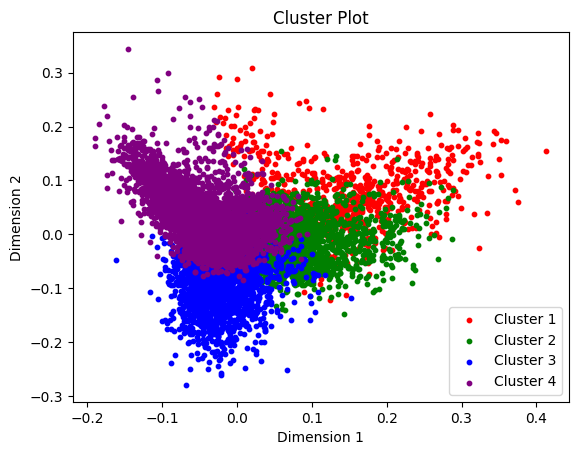

In [38]:
# plot the results 
colors = ['red', 'green', 'blue', 'purple']
cluster = [1, 2, 3, 4] 
for i in range(num_clusters):
    plt.scatter(reduced_data[kmeans.labels_ == i, 0], 
                reduced_data[kmeans.labels_ == i, 1],  
                s=10, color=colors[i],  
                label=f'Cluster {cluster[i]}')

plt.title('Cluster Plot')
plt.xlabel('Dimension 1')
plt.ylabel('Dimension 2')
plt.legend()
plt.show()